# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
import pickle

def load_traffic_sign_data(training_file, testing_file):
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    return train, test

# Load pickled data
train, test = load_traffic_sign_data('data/train.p', 'data/test.p')
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
import numpy as np

# Number of examples
n_train, n_test = X_train.shape[0], X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many classes?
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples  =", n_test)
print("Image data shape  =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples  = 12630
Image data shape  = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s).

- First we can visualize some images sampled from training set:

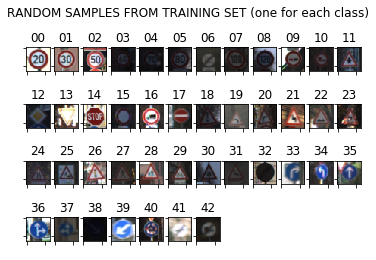

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# show a random sample from each class of the traffic sign dataset
rows, cols = 4, 12
fig, ax_array = plt.subplots(rows, cols)
plt.suptitle('RANDOM SAMPLES FROM TRAINING SET (one for each class)')
for class_idx, ax in enumerate(ax_array.ravel()):
    if class_idx < n_classes:
        # show a random image of the current class
        cur_X = X_train[y_train == class_idx]
        cur_img = cur_X[np.random.randint(len(cur_X))]
        ax.imshow(cur_img)
        ax.set_title('{:02d}'.format(class_idx))
    else:
        ax.axis('off')
# hide both x and y ticks
plt.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)
plt.draw()

- We can also get the idea of how these classes are distributed in both training and testing set

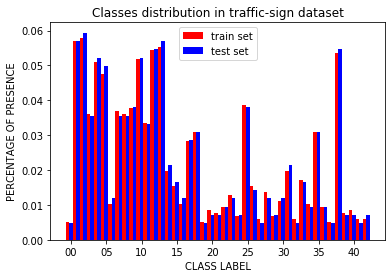

In [5]:
# bar-chart of classes distribution
train_distribution, test_distribution = np.zeros(n_classes), np.zeros(n_classes)
for c in range(n_classes):
    train_distribution[c] = np.sum(y_train == c) / n_train
    test_distribution[c] = np.sum(y_test == c) / n_test
fig, ax = plt.subplots()
col_width = 0.5
bar_train = ax.bar(np.arange(n_classes), train_distribution, width=col_width, color='r')
bar_test = ax.bar(np.arange(n_classes)+col_width, test_distribution, width=col_width, color='b')
ax.set_ylabel('PERCENTAGE OF PRESENCE')
ax.set_xlabel('CLASS LABEL')
ax.set_title('Classes distribution in traffic-sign dataset')
ax.set_xticks(np.arange(0, n_classes, 5)+col_width)
ax.set_xticklabels(['{:02d}'.format(c) for c in range(0, n_classes, 5)])
ax.legend((bar_train[0], bar_test[0]), ('train set', 'test set'))
plt.show()

From this plot we notice that there's a strong *imbalance among the classes*. Indeed, some classes are relatively over-represented, while some others are much less common. However, we see that the data distribution is almost the same between training and testing set, and this is good news: looks like we won't have problem related to *dataset shift* when we'll evaluate our model on the test data.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.


### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

**Feature preprocessing**

In [6]:
import cv2 

def preprocess_features(X, equalize_hist=True):

    # convert from RGB to YUV
    X = np.array([np.expand_dims(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YUV)[:, :, 0], 2) for rgb_img in X])

    # adjust image contrast
    if equalize_hist:
        X = np.array([np.expand_dims(cv2.equalizeHist(np.uint8(img)), 2) for img in X])

    X = np.float32(X)

    # standardize features
    X -= np.mean(X, axis=0)
    X /= (np.std(X, axis=0) + np.finfo('float32').eps)

    return X

X_train_norm = preprocess_features(X_train)
X_test_norm = preprocess_features(X_test)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
Following this paper [[Sermanet, LeCun]](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) I employed three main steps of feature preprocessing:

1) *each image is converted from RGB to YUV color space, then only the Y channel is used.* This choice can sound at first suprising, but the cited paper shows how this choice leads to the best performing model. This is slightly counter-intuitive, but if we think about it arguably we are able to distinguish all the traffic signs just by looking to the grayscale image.

2) *contrast of each image is adjusted by means of histogram equalization*. This is to mitigate the numerous situation in which the image contrast is really poor.

3) *each image is centered on zero mean and divided for its standard deviation*. This feature scaling is known to have beneficial effects on the gradient descent performed by the optimizer.

Using TensorFlow backend.
/home/shengchen/tensorflow/envPy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shengchen/tensorflow/envPy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shengchen/tensorflow/envPy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shengchen/tensorf

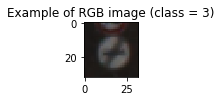

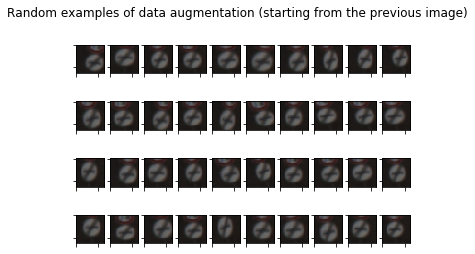

In [7]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# split into train and validation
VAL_RATIO = 0.2
X_train_norm, X_val_norm, y_train, y_val = train_test_split(X_train_norm, y_train, test_size=VAL_RATIO, random_state=0)


# create the generator to perform online data augmentation
image_datagen = ImageDataGenerator(rotation_range=15.,
                                   zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

# take a random image from the training set
img_rgb = X_train[0]

# plot the original image
plt.figure(figsize=(1,1))
plt.imshow(img_rgb)
plt.title('Example of RGB image (class = {})'.format(y_train[0]))
plt.show()

# plot some randomly augmented images
rows, cols = 4, 10
fig, ax_array = plt.subplots(rows, cols)
for ax in ax_array.ravel():
    augmented_img, _ = image_datagen.flow(np.expand_dims(img_rgb, 0), y_train[0:1]).next()
    ax.imshow(np.uint8(np.squeeze(augmented_img)))
plt.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)
plt.suptitle('Random examples of data augmentation (starting from the previous image)')
plt.show()

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** For the *train and test split*, I just used the ones provided, composed by 39209 and 12630 examples respectively.


To get *additional data*, I leveraged on the `ImageDataGenerator` class provided in the [Keras](https://keras.io/preprocessing/image/) library. No need to re-invent the wheel! In this way I could perform data augmentation online, during the training. Training images are randomly rotated, zoomed and shifted but just in a narrow range, in order to create some variety in the data while not completely twisting the original feature content. The result of this process of augmentation is visible in the previous figure.

In [8]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten


def weight_variable(shape, mu=0, sigma=0.1):
    initialization = tf.truncated_normal(shape=shape, mean=mu, stddev=sigma)
    return tf.Variable(initialization)


def bias_variable(shape, start_val=0.1):
    initialization = tf.constant(start_val, shape=shape)
    return tf.Variable(initialization)


def conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME'):
    return tf.nn.conv2d(input=x, filter=W, strides=strides, padding=padding)


def max_pool_2x2(x):
    return tf.nn.max_pool(value=x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


# network architecture definition
def my_net(x, n_classes):

    c1_out = 64
    conv1_W = weight_variable(shape=(3, 3, 1, c1_out))
    conv1_b = bias_variable(shape=(c1_out,))
    conv1 = tf.nn.relu(conv2d(x, conv1_W) + conv1_b)

    pool1 = max_pool_2x2(conv1)

    drop1 = tf.nn.dropout(pool1, keep_prob=keep_prob)

    c2_out = 128
    conv2_W = weight_variable(shape=(3, 3, c1_out, c2_out))
    conv2_b = bias_variable(shape=(c2_out,))
    conv2 = tf.nn.relu(conv2d(drop1, conv2_W) + conv2_b)

    pool2 = max_pool_2x2(conv2)

    drop2 = tf.nn.dropout(pool2, keep_prob=keep_prob)

    fc0 = tf.concat(1, [flatten(drop1), flatten(drop2)])

    fc1_out = 64
    fc1_W = weight_variable(shape=(fc0._shape[1].value, fc1_out))
    fc1_b = bias_variable(shape=(fc1_out,))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b

    drop_fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)

    fc2_out = n_classes
    fc2_W = weight_variable(shape=(drop_fc1._shape[1].value, fc2_out))
    fc2_b = bias_variable(shape=(fc2_out,))
    logits = tf.matmul(drop_fc1, fc2_W) + fc2_b

    return logits


# placeholders
x = tf.placeholder(dtype=tf.float32, shape=(None, 32, 32, 1))
y = tf.placeholder(dtype=tf.int32, shape=None)
keep_prob = tf.placeholder(tf.float32)


# training pipeline
lr = 0.001
logits = my_net(x, n_classes=n_classes)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss_function = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_step = optimizer.minimize(loss=loss_function)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.flatten instead.


ValueError: Dimension 1 in both shapes must be equal, but are 16384 and 8192. Shapes are [?,16384] and [?,8192].
	From merging shape 0 with other shapes. for 'concat/concat_dim' (op: 'Pack') with input shapes: [?,16384], [?,8192].

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_


**Answer:** The final architecture is a relatively shallow network made by 4 layers. The first two layers are convolutional, while the third and last are fully connected. Following [[Sermanet, LeCun]](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) the output of both the first and second convolutional layers are concatenated and fed to the following dense layer. In this way we provide the fully-connected layer visual patterns at both different levels of abstraction. The last fully-connected layer then maps the prediction into one of the 43 classes.

In [9]:
# metrics and functions for model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.cast(y, tf.int64))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    
    num_examples = X_data.shape[0]
    total_accuracy = 0
    
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCHSIZE):
        batch_x, batch_y = X_data[offset:offset+BATCHSIZE], y_data[offset:offset+BATCHSIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += accuracy * len(batch_x)
        
    return total_accuracy / num_examples

# create a checkpointer to log the weights during training
checkpointer = tf.train.Saver()

NameError: name 'logits' is not defined

In [10]:
# training hyperparameters
BATCHSIZE = 128
EPOCHS = 30
BATCHES_PER_EPOCH = 5000

In [11]:
# start training
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    for epoch in range(EPOCHS):

        print("EPOCH {} ...".format(epoch + 1))

        batch_counter = 0
        for batch_x, batch_y in image_datagen.flow(X_train_norm, y_train, batch_size=BATCHSIZE):

            batch_counter += 1
            sess.run(train_step, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

            if batch_counter == BATCHES_PER_EPOCH:
                break

        # at epoch end, evaluate accuracy on both training and validation set
        train_accuracy = evaluate(X_train_norm, y_train)
        val_accuracy = evaluate(X_val_norm, y_val)
        print('Train Accuracy = {:.3f} - Validation Accuracy: {:.3f}'.format(train_accuracy, val_accuracy))
        
        # log current weights
        checkpointer.save(sess, save_path='../checkpoints/traffic_sign_model.ckpt', global_step=epoch)

EPOCH 1 ...


NameError: name 'train_step' is not defined

Now we can test the model. Let's load the weights of the epoch with the highest accuracy on validation set, which are the most promising :-)

In [12]:
# testing the model
with tf.Session() as sess:

    # restore saved session with highest validation accuracy
    checkpointer.restore(sess, '../checkpoints/traffic_sign_model.ckpt-27')
    
    test_accuracy = evaluate(X_test_norm, y_test)
    print('Performance on test set: {:.3f}'.format(test_accuracy))


NameError: name 'checkpointer' is not defined

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** For the trainig I used *Adam optimizer*, which often proves to be a good choice to avoid the patient search of the right parameters for SGD. *Batchsize* was set to 128 due to memory constraint. Every 5000 batches visited, an evaluation on both training and validation set is performed. In order to avoid overfitting, both data augmentation and dropout (with drop probability of 0.5) are employed extensively.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** The network architecture is based on the paper [[Sermanet, LeCun]](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), in which the authors tackle the same problem (traffic sign classification), though using a different dataset. In section *II-A* of the paper, the authors explain that they found beneficial to feed the dense layers with the output of both the previous convolutional layers. Indeed, in this way the classifier is explicitly provided both the local "motifs" (learned by conv1) and the more "global" shapes and structure (learned by conv2) found in the features. I tried to replicate the same architecture, made by 2 convolutional and 2 fully connected layers. The number of features learned was lowered until the training was feasible also in my laptop!

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [13]:
### Load the images and plot them here.
import os

# load new images
new_images_dir = '../other_signs'
new_test_images = [os.path.join(new_images_dir, f) for f in os.listdir(new_images_dir)]
new_test_images = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in new_test_images]

# manually annotated labels for these new images
new_targets = [1, 13, 17, 35, 40]

# plot new test images
fig, axarray = plt.subplots(1, len(new_test_images))
for i, ax in enumerate(axarray.ravel()):
    ax.imshow(new_test_images[i])
    ax.set_title('{}'.format(i))
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_xticks([]), ax.set_yticks([])


FileNotFoundError: [Errno 2] No such file or directory: '../other_signs'

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** All the previous 5 images are taken from real-world videos, thus they're far from being perfectly "clean". For example, in figure 4 ("roundabout mandatory" sign) the image contrast is so bad that it's barely possible to recognize its meaning.

Let's test the trained model on these bare new images: 

In [80]:
# first things first: feature preprocessing
new_test_images_norm = preprocess_features(new_test_images)

with tf.Session() as sess:

    # restore saved session
    checkpointer.restore(sess, '../checkpoints/traffic_sign_model.ckpt-27')

    # predict on unseen images
    prediction = np.argmax(np.array(sess.run(logits, feed_dict={x: new_test_images_norm, keep_prob: 1.})), axis=1)

for i, pred in enumerate(prediction):
    print('Image {} - Target = {:02d}, Predicted = {:02d}'.format(i, new_targets[i], pred))
    
print('> Model accuracy: {:.02f}'.format(np.sum(new_targets==prediction)/len(new_targets)))

Image 0 - Target = 01, Predicted = 01
Image 1 - Target = 13, Predicted = 13
Image 2 - Target = 17, Predicted = 02
Image 3 - Target = 35, Predicted = 35
Image 4 - Target = 40, Predicted = 40
> Model accuracy: 0.80


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._


**Answer:** Evaluated on these 5 newly captured pictures, the model accuracy results 80%. While it's true that the performance drop w.r.t. the test set is high (around 15%), we must keep in mind that 5 images are too few to be of any statistical significance. 

Visualizing softmax score can give us a better idea about the classification process. Let's see:

Top 3 model predictions for image 0 (Target is 01)
   Prediction = 01 with confidence 0.99
   Prediction = 02 with confidence 0.01
   Prediction = 05 with confidence 0.00
Top 3 model predictions for image 1 (Target is 13)
   Prediction = 13 with confidence 0.99
   Prediction = 38 with confidence 0.00
   Prediction = 12 with confidence 0.00
Top 3 model predictions for image 2 (Target is 17)
   Prediction = 02 with confidence 0.31
   Prediction = 38 with confidence 0.27
   Prediction = 17 with confidence 0.22
Top 3 model predictions for image 3 (Target is 35)
   Prediction = 35 with confidence 0.34
   Prediction = 03 with confidence 0.30
   Prediction = 08 with confidence 0.13
Top 3 model predictions for image 4 (Target is 40)
   Prediction = 40 with confidence 0.44
   Prediction = 12 with confidence 0.39
   Prediction = 38 with confidence 0.11


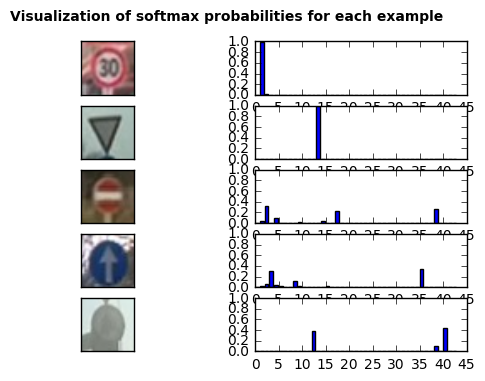

In [79]:
# visualizing softmax probabilities
with tf.Session() as sess:

    # restore saved session
    checkpointer.restore(sess, '../checkpoints/traffic_sign_model.ckpt-27')

    # certainty of predictions
    K = 3
    top_3 = sess.run(tf.nn.top_k(logits, k=K), feed_dict={x: new_test_images_norm, keep_prob: 1.})

    # compute softmax probabilities
    softmax_probs = sess.run(tf.nn.softmax(logits), feed_dict={x: new_test_images_norm, keep_prob: 1.})

# plot softmax probs along with traffic sign examples
n_images = new_test_images_norm.shape[0]
fig, axarray = plt.subplots(n_images, 2)
plt.suptitle('Visualization of softmax probabilities for each example', fontweight='bold')
for r in range(0, n_images):
    axarray[r, 0].imshow(np.squeeze(new_test_images[r]))
    axarray[r, 0].set_xticks([]), axarray[r, 0].set_yticks([])
    plt.setp(axarray[r, 0].get_xticklabels(), visible=False)
    plt.setp(axarray[r, 0].get_yticklabels(), visible=False)
    axarray[r, 1].bar(np.arange(n_classes), softmax_probs[r])
    axarray[r, 1].set_ylim([0, 1])
    
# print top K predictions of the model for each example, along with confidence (softmax score)    
for i in range(len(new_test_images)):
    print('Top {} model predictions for image {} (Target is {:02d})'.format(K, i, new_targets[i]))
    for k in range(K):
        top_c = top_3[1][i][k]
        print('   Prediction = {:02d} with confidence {:.2f}'.format(top_c, softmax_probs[i][top_c]))


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

**Answer:** As immediately emerges from the plot above, our model is quite sure of which class the first two traffic sign belong, but it's slightly confused on the other three. Indeed, in the first two cases the model is not only able to predict the right class, but shows also an high confidence. For the third example (no-entry sign) model's prediction is wrong, nonetheless the correct target appears in the top 3 predictions, which is encouraging. Finally, the last two examples are correctly predicted: even the last one (roundabout mandatory), which is quite difficult if we trust our eyes! However, the softmax distribution does not lie: for these last two images the model is not so sure about which is the right label.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.